<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimization-based-controller" data-toc-modified-id="Optimization-based-controller-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimization based-controller</a></span></li></ul></div>

In this notebook, I explore a new technique for synthesizing controller. The gist of this new technique is that: rather than trying to find the closed-loop mappings $\{R, M, N, L\}$, or rather, their impulse responses, directly, we find a convex combination of known controllers that satisfies the specification. 

The expected advantages of this method is mainly computational. Synthesis1--the previous approach--couldn't solve for responses with impulse mappings longer than 374 even for the modest 1-dof problem I throw at it. This is a clear disadvantage.

In [4]:
# previous synthesis script
from Oct23_1dof_admittance import plant
# standard libs
import SLSsyn as Ss
import numpy as np
import control as co
import matplotlib.pyplot as plt

In [8]:
# constants
dT = 0.008

The nominal model is that of a human with a *net stiffness* of 50 (N/m), and slight time delay of 0.05 second. This model can be found below.

A remarkable, and unfortunate, fact is that even for this 
relatively simple model with a single robot joint, the nominal model has 9 states. You can check this by looking at the shape of matrix A of `Pssd_design`. 

The reason why this is unfortunate is that the response mapping $R$ is a $nx\times nx$ transfer matrix that contains, in this simple case, 81 different transfer function. Even if all of them are stable, you need a large computational power to get hold of them.



In [11]:
Ptf_design = plant(Hdelay=0.05, Hgain=50)
Pss_design = Ss.tf2ss(Ptf_design, minreal=True)
Pssd_design = co.c2d(Pss_design, dT)

Consider the following Admittance controller 
$$
   \frac{u}{y} = \frac{1}{s^2 + 6s + 5}
$$

In [25]:
A1c = co.tf([1], [1, 6, 5])
A1d = co.c2d(A1c, dT)
A1dss = Ss.mtf2ss(A1d)
print(A1dss)

A = [[ 1.95282135e+00  9.53133787e-01]
 [-1.00000000e+00  3.33066907e-16]]

B = [[1.]
 [0.]]

C = [[ 3.14932484e-05 -3.09933693e-05]]

D = [[0.]]

dt = 0.008



The SLS closed-loop mapping can be computed using equation (21) in (Wang, 2016).

In [127]:
# function: compute_closed_loop_mappings R, N, M, L
nu = A1dss.outputs
ny = A1dss.inputs
nxc = A1dss.states
nx = Pssd_design.states

# form the state-space form of the combined closed-loop mappings transfer function
A, B1, B2, C1, C2, D11, D12, D21, D22 = map(np.array, Ss.get_partitioned_mats(Pssd_design, nu, ny))
Ak, Bk, Ck, Dk = A1dss.A, A1dss.B, A1dss.C, A1dss.D
assert np.all(D22 == 0)

# Concatenate system matrices to find the matrices of the ss rep of the impulse response mapping
# [R N] =   A_cb  |  B_cb
# [M L]     ------|-------
#           C_cb  |  D_cb
A_cb = np.block([[A + B2.dot(Dk).dot(C2), B2.dot(Ck)],
                 [Bk.dot(C2), Ak]])
B_cb = np.block([[np.eye(nx), B2.dot(Dk)],
                 [np.zeros((nxc, nx)), Bk]])
C_cb = np.block([[np.eye(nx), np.zeros((nx, nxc))],
                 [Dk.dot(C2), Ck]])
D_cb = np.block([[np.zeros((nx, nx)), np.zeros((nx, ny))],
                 [np.zeros((nu, nx)), Dk]])
resp_dss = co.ss(A_cb, B_cb, C_cb, D_cb, dT)

Having now obtained a state-space system that is equivalent to the SLS mapping, that is the following block transfer function
$$
   \begin{bmatrix}
    x \\ u
   \end{bmatrix}
    = 
   \begin{bmatrix}
      R & N \\ M & L
   \end{bmatrix}
   \begin{bmatrix}
   \delta x \\ \delta y
   \end{bmatrix}
$$

We can now compute the impulse response of this system.

It is important to note that the final impulse responses is a three dimensional array. The first dimension is time. The last two dimensions contain the entries of the matrices.

In [204]:
%%capture
# Compute impulse responses of the matrices
Tarr = np.arange(0, 3, dT)  # 5 sec horizon 
NT = Tarr.shape[0]
impulses = []
for i in range(nx + ny):
    _, yarr = co.impulse_response(resp_dss, Tarr, input=i, transpose=True)
    impulses.append(yarr)
impulse_full = np.stack(impulses, axis=2)

# Individual responses
R = impulse_full[:, :nx, :nx]
N = impulse_full[:, :nx, nx:nx + ny]
M = impulse_full[:, nx:nx + nu, :nx]
L = impulse_full[:, nx:nx + nu, nx:nx + ny]
MB2 = M@B2

Now we can visualize the impulse that make up the controller. Interesting.

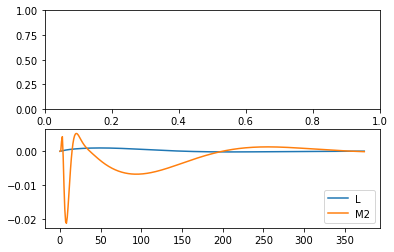

In [205]:
fig, axs = plt.subplots(2, 1)
plt.plot(L.reshape(NT, -1), label='L')
plt.plot(MB2.reshape(NT, -1), label='M2')
plt.legend()
plt.show()

Since the system is stable, a controller can be formed from only the two respones 
L and MB2 that achieves exactly the given closed-loop mapping. To verify that this is indeed the case, we take the reponses L and MB2, form a controller, simulate a response and compare that to the step response of the original system.

In [208]:
# from the two responses L and MB2, we now  FIR-based controller
fir_den = [1] + [0 for n in range(NT - 1)]
MB2_tf = co.tf(MB2[:, 0, 0], fir_den, dT)
L_tf = co.tf(L[:, 0, 0], fir_den, dT)
A1dss_FIR = co.feedback(1, MB2_tf, sign=-1) * L_tf
A1dss_FIR = Ss.mtf2ss(A1dss_FIR, minreal=False)

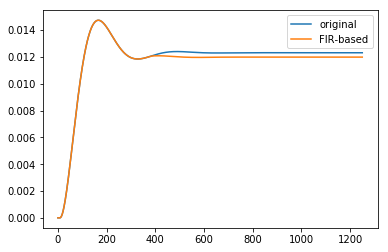

In [209]:
# Original system
Pdss_cl = Ss.lft(Pssd_design, A1dss)
_, yout_step = co.step_response(Pdss_cl, [0, 10], transpose=True)
# FIR-based system
Pdss_cl_FIR = Ss.lft(Pssd_design, A1dss_FIR)
_, yout_step_FIR = co.step_response(Pdss_cl_FIR, [0, 10], transpose=True)

plt.plot(yout_step[:, 0], label='original')
plt.plot(yout_step_FIR[:, 0], label='FIR-based')
plt.legend()
plt.show()

### Optimization based-controller

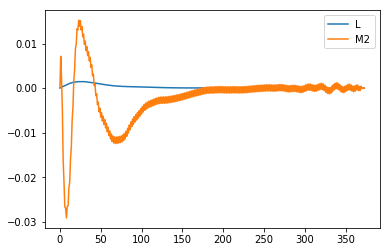

In [190]:
# controller from direct optimization of the impulses
import yaml
with open("../config/super.yaml", 'r') as f:
    doc = yaml.load(f)
L = np.array(doc['fir_siso']['super']['L']).reshape(-1, 1, 1)
MB2 = np.array(doc['fir_siso']['super']['MB2']).reshape(-1, 1, 1)
T = L.shape[0]

plt.plot(L[:, 0, 0], label='L')
plt.plot(MB2[:, 0, 0], label='M2')
plt.legend()
plt.show()

In [179]:
A1dss_FIR.states

974

(array([1.990e-01, 1.986e-01, 1.980e-01, 1.972e-01, 1.962e-01, 1.947e-01,
        1.927e-01, 1.900e-01, 1.864e-01, 1.818e-01, 1.757e-01, 1.682e-01,
        1.591e-01, 1.484e-01, 1.363e-01, 1.232e-01, 1.096e-01, 9.589e-02,
        8.261e-02, 7.007e-02, 5.852e-02, 4.811e-02, 3.892e-02, 3.098e-02,
        2.427e-02, 1.872e-02, 1.423e-02, 1.068e-02, 7.935e-03, 5.843e-03,
        4.272e-03, 3.107e-03, 2.250e-03, 1.625e-03, 1.170e-03, 8.411e-04,
        6.037e-04, 4.327e-04, 3.097e-04, 2.214e-04, 1.579e-04, 1.124e-04,
        7.970e-05, 5.623e-05, 3.935e-05, 2.717e-05, 1.832e-05, 1.177e-05,
        6.751e-06, 2.569e-06]),
 array([-0.12 , -0.142, -0.167, -0.197, -0.232, -0.273, -0.321, -0.376,
        -0.44 , -0.513, -0.595, -0.686, -0.787, -0.895, -1.009, -1.128,
        -1.25 , -1.375, -1.5  , -1.626, -1.751, -1.877, -2.001, -2.124,
        -2.242, -2.355, -2.462, -2.561, -2.652, -2.735, -2.81 , -2.878,
        -2.94 , -2.998, -3.052, -3.104, -3.156, -3.208, -3.261, -3.319,
        -3.381, 

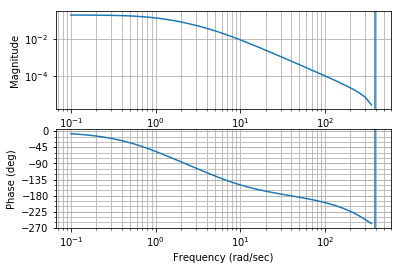

In [150]:
# bode plots
co.bode(A1dss)

(array([0.961, 0.961, 0.962, 0.963, 0.965, 0.968, 0.973, 0.982, 0.997,
        1.022, 1.06 , 1.081, 0.966, 0.669, 0.483, 0.433, 0.407, 0.357,
        0.335, 0.448, 0.588, 0.637, 0.569, 0.482, 0.437, 0.383, 0.292,
        0.199, 0.135, 0.103]),
 array([-0.009, -0.011, -0.015, -0.02 , -0.027, -0.037, -0.051, -0.071,
        -0.101, -0.15 , -0.24 , -0.415, -0.696, -0.864, -0.737, -0.578,
        -0.523, -0.472, -0.235, -0.117, -0.362, -0.774, -1.206, -1.56 ,
        -1.977, -2.576, -3.316, -4.113, -4.957, -5.904]),
 array([1.000e-01, 1.326e-01, 1.758e-01, 2.330e-01, 3.089e-01, 4.095e-01,
        5.429e-01, 7.197e-01, 9.541e-01, 1.265e+00, 1.677e+00, 2.223e+00,
        2.947e+00, 3.907e+00, 5.179e+00, 6.866e+00, 9.103e+00, 1.207e+01,
        1.600e+01, 2.121e+01, 2.812e+01, 3.728e+01, 4.942e+01, 6.551e+01,
        8.685e+01, 1.151e+02, 1.526e+02, 2.024e+02, 2.683e+02, 3.556e+02]))

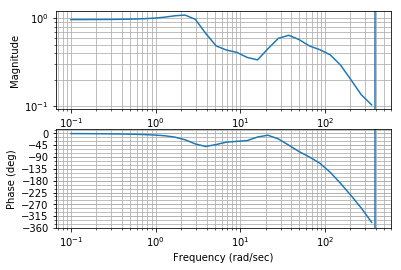

In [153]:
co.bode(A1dss_FIR)

In [114]:
M.shape

(625, 1, 9)